In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision 
from torchvision.models import vit_b_16, ViT_B_16_Weights 
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Using GPU: Tesla P100-PCIE-16GB


In [3]:
# 資料集路徑

# dataset_folder = '/kaggle/input/esc50-adaf-spectrograms-128amplitude/ESC50_Adaf_Spectrograms_128(Amplitude)'
# dataset_folder = '/kaggle/input/esc50-adaf-spectrograms-128power/ESC50_Adaf_Spectrograms_128(Power)'
# dataset_folder = '/kaggle/input/esc50-adaf-spectrograms-128db/ESC50_Adaf_Spectrograms_128(DB)'
# -------------------------------------------------------------------------------------------------
# dataset_folder = '/kaggle/input/esc50-spectrogramsamplitude/ESC50_Spectrograms(Amplitude)'
# dataset_folder = '/kaggle/input/esc50-spectrogramspower/ESC50_Spectrograms(Power)'
# dataset_folder = '/kaggle/input/esc50-spectrogramsdb/ESC50_Spectrograms(DB)'
#-------------------------------------------------------------------------------------------------
dataset_folder = '/kaggle/input/esc50-mel-spectrograms-128/ESC50_Mel_Spectrograms_128'
#-------------------------------------------------------------------------------------------------
meta_csv_path = '/kaggle/input/esc50-infor/esc50.csv'

In [4]:
meta_df = pd.read_csv(meta_csv_path)
label_encoder = LabelEncoder()
meta_df['target'] = label_encoder.fit_transform(meta_df['category'])
meta_df['image_path'] = meta_df['filename'].apply(
    lambda f: os.path.join(dataset_folder, f.replace('.wav', '.png'))
)

In [5]:
# --- Torchvision ViT ---
class TorchvisionViTModel(nn.Module):
    def __init__(self, num_classes=50):
        super(TorchvisionViTModel, self).__init__()
        

        weights = ViT_B_16_Weights.IMAGENET1K_V1
        self.vit = vit_b_16(weights=weights)

        # 取得原始 patch embedding 層的權重並平均
        # 在 torchvision ViT 中，這一層叫做 "conv_proj"
        original_conv_proj = self.vit.conv_proj
        original_weights = original_conv_proj.weight.detach().clone()
        new_weights = original_weights.mean(dim=1, keepdim=True) 

        out_channels = original_conv_proj.out_channels
        kernel_size = original_conv_proj.kernel_size
        stride = original_conv_proj.stride
        
        self.vit.conv_proj = nn.Conv2d(1, out_channels, kernel_size=kernel_size, stride=stride)
        

        self.vit.conv_proj.weight = nn.Parameter(new_weights)
        
        in_features = self.vit.heads.head.in_features
        self.vit.heads.head = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

In [6]:
class SpectrogramDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform # 使用 torchvision 的 transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        image = Image.open(img_path).convert('L')
        label = self.labels[idx]
        

        if self.transform:
            image = self.transform(image)
            
        return image, label

In [7]:
MONO_MEAN = [0.449]#新的 Mean: (0.485 + 0.456 + 0.406) / 3 ≈ 0.449
MONO_STD = [0.226]#新的 Std: (0.229 + 0.224 + 0.225) / 3 ≈ 0.226

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    transforms.ToTensor(), 
    transforms.Normalize(mean=MONO_MEAN, std=MONO_STD) 
])
print("Transforms:\n", transform)

Transforms:
 Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.449], std=[0.226])
)


In [9]:
# Store metrics for each fold
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []
fold_auc_scores = []

In [10]:
for fold_num in sorted(meta_df['fold'].unique()):
    print(f"\n=== Fold {fold_num}/5 ===")

    train_df = meta_df[meta_df['fold'] != fold_num]
    val_df = meta_df[meta_df['fold'] == fold_num]

    train_images = train_df['image_path'].values
    train_labels = train_df['target'].values
    val_images = val_df['image_path'].values
    val_labels = val_df['target'].values

    # 建立 Dataset 和 DataLoader
    train_dataset = SpectrogramDataset(train_images, train_labels, transform=transform)
    val_dataset = SpectrogramDataset(val_images, val_labels, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=32,shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

    model = TorchvisionViTModel(num_classes=50).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4) 
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    num_epochs = 25
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    auc_scores = []

    
    
    # 訓練迴圈
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            labels = labels.long().view(-1).to(device)
            images = images.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)
        
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_true = []
        all_probs = []

        with torch.no_grad():
            for images, labels in val_loader:
                labels = labels.long().view(-1).to(device)
                images = images.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = torch.argmax(outputs, dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                all_true.extend(labels.cpu().numpy())
                all_probs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

        val_accuracy = correct / total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)
        
        auc = roc_auc_score(all_true, all_probs, multi_class='ovo', average='macro')
        auc_scores.append(auc)
        scheduler.step(val_losses[-1])

        # Print metrics for each epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}, AUC: {auc:.4f}, '
              f'Learning Rate: {optimizer.param_groups[0]["lr"]:.8f}')

    # 儲存和記錄每個 fold 的結果
    model_path = f'ESC-50_Torchvision_ViT1_Mel_Spectrograms_128_5fold_{fold_num}.pth'
    torch.save(model.state_dict(), model_path)
    print(f"--- Model for Fold {fold_num} saved to {model_path} ---")
    
    fold_train_losses.append(train_losses[-1])
    fold_val_losses.append(val_losses[-1])
    fold_train_accuracies.append(train_accuracies[-1])
    fold_val_accuracies.append(val_accuracies[-1])
    fold_auc_scores.append(auc_scores[-1])


=== Fold 1/5 ===


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 198MB/s] 


Epoch 1/25, Train Loss: 3.5912, Train Accuracy: 0.1688, Val Loss: 3.1773, Val Accuracy: 0.3275, AUC: 0.9049, Learning Rate: 0.00001000
Epoch 2/25, Train Loss: 2.5662, Train Accuracy: 0.5431, Val Loss: 2.3595, Val Accuracy: 0.5500, AUC: 0.9593, Learning Rate: 0.00001000
Epoch 3/25, Train Loss: 1.7553, Train Accuracy: 0.7444, Val Loss: 1.8545, Val Accuracy: 0.6475, AUC: 0.9738, Learning Rate: 0.00001000
Epoch 4/25, Train Loss: 1.2352, Train Accuracy: 0.8375, Val Loss: 1.5617, Val Accuracy: 0.6825, AUC: 0.9825, Learning Rate: 0.00001000
Epoch 5/25, Train Loss: 0.9033, Train Accuracy: 0.8938, Val Loss: 1.3578, Val Accuracy: 0.7125, AUC: 0.9870, Learning Rate: 0.00001000
Epoch 6/25, Train Loss: 0.6665, Train Accuracy: 0.9419, Val Loss: 1.2044, Val Accuracy: 0.7250, AUC: 0.9888, Learning Rate: 0.00001000
Epoch 7/25, Train Loss: 0.4857, Train Accuracy: 0.9606, Val Loss: 1.1166, Val Accuracy: 0.7250, AUC: 0.9901, Learning Rate: 0.00001000
Epoch 8/25, Train Loss: 0.3463, Train Accuracy: 0.9856,

In [11]:
mean_train_loss = np.mean(fold_train_losses)
std_train_loss = np.std(fold_train_losses)
mean_val_loss = np.mean(fold_val_losses)
std_val_loss = np.std(fold_val_losses)

mean_train_acc = np.mean(fold_train_accuracies)
std_train_acc = np.std(fold_train_accuracies)
mean_val_acc = np.mean(fold_val_accuracies)
std_val_acc = np.std(fold_val_accuracies)

mean_auc = np.mean(fold_auc_scores)
std_auc = np.std(fold_auc_scores)

# Print final results
print("Cross-Validation Results:")

print(f"Average Train Loss:     {mean_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Average Validation Loss:  {mean_val_loss:.4f} ± {std_val_loss:.4f}")

print(f"Average Train Accuracy:   {mean_train_acc*100:.2f} ± {std_train_acc*100:.2f} %")
print(f"Average Validation Acc:   {mean_val_acc*100:.2f} ± {std_val_acc*100:.2f} %")
print(f"Average Validation AUC:   {mean_auc:.2f} ± {std_auc:.2f}")
print(f"Average Validation AUC:   {mean_auc:} ± {std_auc:}")

Cross-Validation Results:
Average Train Loss:     0.0215 ± 0.0006
Average Validation Loss:  0.7835 ± 0.0512
Average Train Accuracy:   100.00 ± 0.00 %
Average Validation Acc:   79.20 ± 1.64 %
Average Validation AUC:   0.99 ± 0.00
Average Validation AUC:   0.9901211734693878 ± 0.002329704635366172


In [12]:
# 計算訓練集各類別的張數
train_class_counts = {}
for _, label in train_dataset:
    train_class_counts[label] = train_class_counts.get(label, 0) + 1

# 印出各類別的張數
print("訓練集各類別的張數:")
for label, count in train_class_counts.items():
    print(f"類別 {label}: {count} 張")

# 計算測試集各類別的張數
test_class_counts = {}
for _, label in val_dataset:
    test_class_counts[label] = test_class_counts.get(label, 0) + 1

# 印出各類別的張數
print("測試集各類別的張數:")
for label, count in test_class_counts.items():
    print(f"類別 {label}: {count} 張")

訓練集各類別的張數:
類別 18: 32 張
類別 7: 32 張
類別 46: 32 張
類別 43: 32 張
類別 20: 32 張
類別 3: 32 張
類別 16: 32 張
類別 9: 32 張
類別 23: 32 張
類別 6: 32 張
類別 0: 32 張
類別 33: 32 張
類別 35: 32 張
類別 45: 32 張
類別 39: 32 張
類別 48: 32 張
類別 8: 32 張
類別 10: 32 張
類別 31: 32 張
類別 49: 32 張
類別 24: 32 張
類別 25: 32 張
類別 13: 32 張
類別 2: 32 張
類別 4: 32 張
類別 14: 32 張
類別 28: 32 張
類別 21: 32 張
類別 36: 32 張
類別 30: 32 張
類別 32: 32 張
類別 29: 32 張
類別 22: 32 張
類別 1: 32 張
類別 17: 32 張
類別 27: 32 張
類別 12: 32 張
類別 26: 32 張
類別 42: 32 張
類別 44: 32 張
類別 34: 32 張
類別 47: 32 張
類別 11: 32 張
類別 41: 32 張
類別 37: 32 張
類別 38: 32 張
類別 40: 32 張
類別 5: 32 張
類別 19: 32 張
類別 15: 32 張
測試集各類別的張數:
類別 34: 8 張
類別 40: 8 張
類別 49: 8 張
類別 47: 8 張
類別 2: 8 張
類別 17: 8 張
類別 25: 8 張
類別 44: 8 張
類別 43: 8 張
類別 23: 8 張
類別 19: 8 張
類別 5: 8 張
類別 6: 8 張
類別 32: 8 張
類別 28: 8 張
類別 12: 8 張
類別 8: 8 張
類別 4: 8 張
類別 36: 8 張
類別 46: 8 張
類別 14: 8 張
類別 41: 8 張
類別 45: 8 張
類別 13: 8 張
類別 37: 8 張
類別 30: 8 張
類別 39: 8 張
類別 38: 8 張
類別 11: 8 張
類別 18: 8 張
類別 21: 8 張
類別 15: 8 張
類別 31: 8 張
類別 35: 8 張
類別 9: 8 張
類別 22: 8 

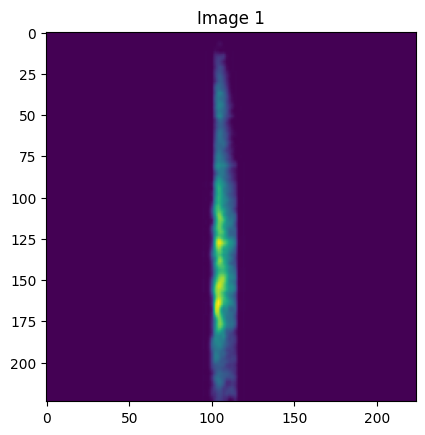

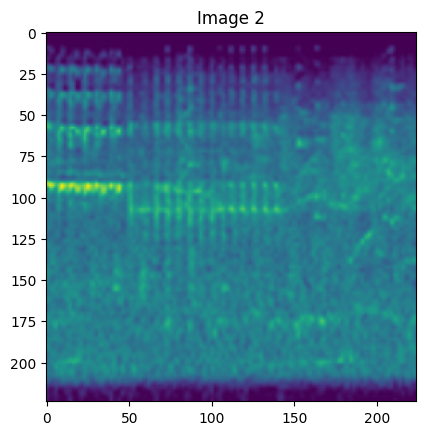

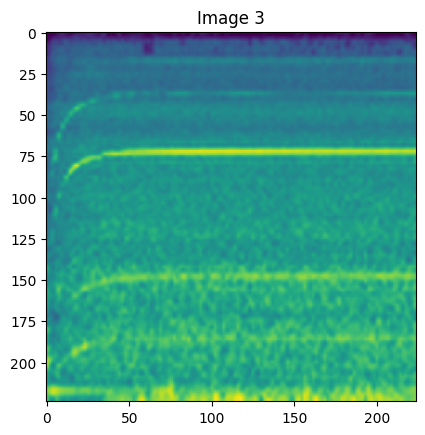

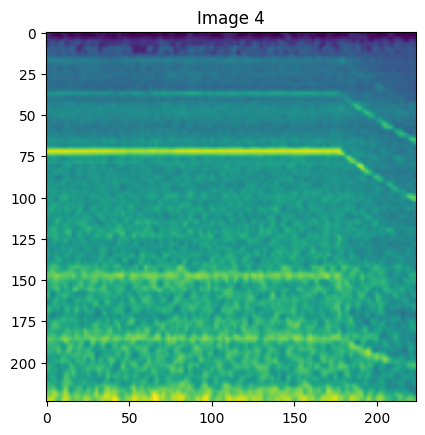

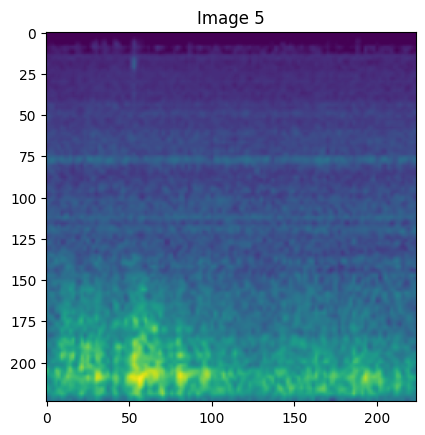

In [13]:
# Display
for i in range(5):
    image, _ = train_dataset[i]
    np_image = image.permute(1, 2, 0).numpy()
    plt.imshow(np_image)
    plt.title(f"Image {i+1}")
    plt.show()